### Inicio Spark Session
En esta primera celda importamos y configuramos todo lo necesario para iniciar nuestra sesión de Spark

In [1]:
import $ivy.`org.apache.spark::spark-sql:2.4.3`


import org.apache.spark.sql._
import org.apache.spark.sql.functions._


//Reducir numero logs
import org.apache.log4j.{Level, Logger}
Logger.getLogger("org").setLevel(Level.OFF)


//For adding extra dependenies
import $ivy.`org.typelevel::cats-core:1.6.0`

//Plotly
import $ivy.`org.plotly-scala::plotly-almond:0.7.1`
import plotly._, plotly.element._, plotly.layout._, plotly.Almond._


//Iniciamos session de Spark
val spark = {
  NotebookSparkSession.builder()
     .master("local[*]")
    //.config("spark.executor.instances", "4") // Número de ejecutores
    //.config("spark.executor.memory", "4g") // Memoria por ejecutor
    //.config("spark.executor.cores", "2") // Núcleos por ejecutor
    //.config("spark.driver.memory", "4g") // Memoria del driver
    //.config("spark.sql.shuffle.partitions", "8") // Número de particiones para operaciones de shuffle
    .getOrCreate()
}
import spark.implicits._

Loading spark-stubs
Getting spark JARs
Creating SparkSession


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties


Spark UI

import $ivy.$                                  



import org.apache.spark.sql._

import org.apache.spark.sql.functions._


//Reducir numero logs

import org.apache.log4j.{Level, Logger}

import $ivy.$                               

//Plotly

import $ivy.$                                      

import plotly._, plotly.element._, plotly.layout._, plotly.Almond._


//Iniciamos session de Spark

spark: SparkSession = org.apache.spark.sql.SparkSession@3e42e87b
import spark.implicits._

# Carga de datos
Datos diarios del balance electrico a nivel nacional

In [2]:
val filePath = "../../data/parquet/dsBalanceNacional11-24.parquet"         
val dataFrameBalance: DataFrame = spark.read
  //.option("header", "true") // Si el archivo tiene un encabezado
  //.option("inferSchema", "true") // Para inferir automáticamente el esquema
  //.csv(filePath)
    .parquet(filePath)


val pathDatosConsulta1 = "../../data/parquet/dsDatosBalanceAnuales.parquet"
val datosConsulta1: DataFrame = spark.read
  //.option("header", "true") // Si el archivo tiene un encabezado
  //.option("inferSchema", "true") // Para inferir automáticamente el esquema
  //.csv(filePath)
    .option("encoding", "UTF-8")
    .parquet(pathDatosConsulta1)

parquet at cmd1.sc:6

1 / 1

parquet at cmd1.sc:15

1 / 1

filePath: String = "../../data/parquet/dsBalanceNacional11-24.parquet"
dataFrameBalance: DataFrame = [Familia: string, Tipo: string ... 5 more fields]
pathDatosConsulta1: String = "../../data/parquet/dsDatosBalanceAnuales.parquet"
datosConsulta1: DataFrame = [Año: string, Familia: string ... 8 more fields]

### Creamos los datasets

In [3]:
org.apache.spark.sql.catalyst.encoders.OuterScopes.addOuterScope(this);
case class Balance(
    Familia: String,
    Tipo: String,
    Compuesto: Boolean,
    Fecha: java.sql.Timestamp,
    Valor: Double,
    Porcentaje: Double,
    BajasEmisiones: Boolean
)

val dsBalance: Dataset[Balance] = dataFrameBalance.as[Balance]

defined class Balance
dsBalance: Dataset[Balance] = [Familia: string, Tipo: string ... 5 more fields]

In [4]:
org.apache.spark.sql.catalyst.encoders.OuterScopes.addOuterScope(this);
case class BalanceAnual(
    Año: String,
    Familia: String,
    Tipo: String,
    Compuesto: Boolean,
    BajasEmisiones: Boolean, 
    ValorAnual: Double,
    PorcentajeAnualSobreFamilia: Double, 
    TotalGenerado: Double, 
    PorcentajeSobreTotal: Double, 
    PorcentajeBajasEmisiones: Double
)

val dsBalanceAnual: Dataset[BalanceAnual] = datosConsulta1.as[BalanceAnual]

defined class BalanceAnual
dsBalanceAnual: Dataset[BalanceAnual] = [Año: string, Familia: string ... 8 more fields]

In [6]:
dsBalanceAnual.show()

show at cmd5.sc:1

1 / 1

+----+------------+--------------------+---------+--------------+--------------------+---------------------------+-------------+--------------------+------------------------+
| Año|     Familia|                Tipo|Compuesto|BajasEmisiones|          ValorAnual|PorcentajeAnualSobreFamilia|TotalGenerado|PorcentajeSobreTotal|PorcentajeBajasEmisiones|
+----+------------+--------------------+---------+--------------+--------------------+---------------------------+-------------+--------------------+------------------------+
|2011|   Renovable| Residuos renovables|    false|          true|   736055.7439999997|       0.009459560379872512|2.793538222E8|                0.26|                   50.71|
|2011|No-Renovable|    Turbina de vapor|    false|         false|   2634295.117000001|       0.013977839024369875|2.793538222E8|                0.94|                   50.71|
|2011|     Demanda|Saldo I. internac...|    false|         false|  -6090126.334000002|       0.023054055458754885|2.793538222

In [5]:
import org.apache.spark.sql.functions._

// Suma de la generación renovable y no renovable
val sumaGeneracion = dataFrameBalance
  .filter($"Compuesto" === true)
  .filter($"Tipo".isin("Generación renovable", "Generación no renovable"))
  .groupBy(lit("Generación total").as("Tipo")) // Agrupar bajo el nombre "Generación total"
  .agg(sum("Valor").as("Valor total"))

// Calcular la demanda total en b.c.
val demandaTotalBC = dataFrameBalance
  .filter($"Tipo" === "Demanda en b.c.")
  .agg(sum("Valor").as("DemandaTotal"))

// Calcular la suma de "Consumos en bombeo"
val consumosBombeo = dataFrameBalance
  .filter($"Tipo" === "Consumos en bombeo")
  .agg(sum("Valor").as("ConsumoBombeoTotal"))

// Calcular la suma de "Saldo I. internacionales"
val saldoInternacional = dataFrameBalance
  .filter($"Tipo" === "Saldo I. internacionales")
  .agg(sum("Valor").as("SaldoInternacionalTotal"))

// Realizar la operación demanda total - consumos en bombeo - saldo internacional
val demandaFinal = demandaTotalBC
  .crossJoin(consumosBombeo)
  .crossJoin(saldoInternacional)
  .withColumn("Valor total", $"DemandaTotal" - $"ConsumoBombeoTotal" - $"SaldoInternacionalTotal")
  .select(lit("Demanda neta en b.c.").as("Tipo"), $"Valor total")

// Unir con el DataFrame de generación total
val resultadoFinal = sumaGeneracion.unionByName(demandaFinal)

// Mostrar el resultado final
resultadoFinal.show()


run at ThreadPoolExecutor.java:1149

15 / 15

run at ThreadPoolExecutor.java:1149

15 / 15

run at ThreadPoolExecutor.java:1149

1 / 1

run at ThreadPoolExecutor.java:1149

1 / 1

show at cmd4.sc:36

15 / 15

show at cmd4.sc:36

15 / 15

show at cmd4.sc:36

1 / 1

show at cmd4.sc:36

4 / 4

show at cmd4.sc:36

20 / 20

show at cmd4.sc:36

100 / 100

show at cmd4.sc:36

76 / 76

+--------------------+--------------------+
|                Tipo|         Valor total|
+--------------------+--------------------+
|    Generación total|     3.73662491842E9|
|Demanda neta en b.c.|3.7366249184200006E9|
+--------------------+--------------------+



import org.apache.spark.sql.functions._

// Suma de la generación renovable y no renovable

sumaGeneracion: DataFrame = [Tipo: string, Valor total: double]
demandaTotalBC: DataFrame = [DemandaTotal: double]
consumosBombeo: DataFrame = [ConsumoBombeoTotal: double]
saldoInternacional: DataFrame = [SaldoInternacionalTotal: double]
demandaFinal: DataFrame = [Tipo: string, Valor total: double]
resultadoFinal: Dataset[Row] = [Tipo: string, Valor total: double]

In [10]:
dataFrameBalance
    .filter($"Familia" === "Demanda")
    //.filter($"Tipo" === "Demanda en b.c." || $"Tipo" === "Hidráulica")
    //.orderBy("FechaCompleta")
    //.groupBy(date_format(col("FechaCompleta"), "yyyy").as("Año"))
    //.agg(avg("Valor").as("ValorPromedio"))
    .groupBy($"Tipo").agg(sum("Valor").as("Valor tota"))
    .show()


show at cmd9.sc:7

15 / 15

show at cmd9.sc:7

1 / 1

show at cmd9.sc:7

4 / 4

show at cmd9.sc:7

20 / 20

show at cmd9.sc:7

100 / 100

show at cmd9.sc:7

75 / 75

+--------------------+--------------------+
|                Tipo|          Valor tota|
+--------------------+--------------------+
|     Demanda en b.c.|3.6209275103330007E9|
|  Consumos en bombeo|     -7.0391901946E7|
|Saldo I. internac...|-3.25187588780000...|
+--------------------+--------------------+



In [4]:
//Podemos aplicar map
dataSetBalance.map(b => b.copy(Valor = b.Valor / 1000))
    .show()

show at cmd3.sc:1

1 / 1

+---------+----------+---------+-------------------+------------------+-------------------+--------------+
|  Familia|      Tipo|Compuesto|              Fecha|             Valor|         Porcentaje|BajasEmisiones|
+---------+----------+---------+-------------------+------------------+-------------------+--------------+
|Renovable|Hidráulica|    false|2014-01-01 00:00:00|         73.065052| 0.2070493282098544|          true|
|Renovable|Hidráulica|    false|2014-01-02 00:00:00|         89.171545|0.23631205453294465|          true|
|Renovable|Hidráulica|    false|2014-01-03 00:00:00|        102.502527| 0.2735980903206654|          true|
|Renovable|Hidráulica|    false|2014-01-04 00:00:00|106.84070600000001|0.24018151631870316|          true|
|Renovable|Hidráulica|    false|2014-01-05 00:00:00|        117.217635|0.28984651129433686|          true|
|Renovable|Hidráulica|    false|2014-01-06 00:00:00|        110.841694| 0.3229806730258387|          true|
|Renovable|Hidráulica|    false|2014-

In [8]:
def AnalisisEnergiasAnual(listaEnergias: Seq[String], dataFrameBalance: DataFrame): Unit = {
  // Agrupar y calcular la media para datos renovables
  def calcularMediaAnual(df: DataFrame, tipo: String): DataFrame = {
    df.filter(col("Tipo") === tipo)
      .filter(date_format(col("Fecha"), "yyyy") =!= "2010")  
      .groupBy(date_format(col("Fecha"), "yyyy").as("Año"))
      .agg(sum("Valor").as("ValorPromedio"))
      .orderBy("Año")
  }

  val valores = listaEnergias.map(tipoEnergia => calcularMediaAnual(dataFrameBalance, tipoEnergia))
  val fechas = valores.head.select("Año").as[String].collect.toSeq
  val seqValores = valores.map(valor => valor.select("ValorPromedio").as[Double].collect.toSeq)

  val traces = listaEnergias.zip(seqValores).map { case (nombre, seqValor) =>
    Scatter(fechas, seqValor, name = nombre)
  }

  val data = traces
  plot(data)
}

val EnergiasParaAnalizar = Seq("Hidráulica", "Solar fotovoltaica", "Nuclear", "Ciclo combinado", "Eólica")
AnalisisEnergiasAnual(EnergiasParaAnalizar, dataFrameBalance)

defined class BalanceAnual
dsBalanceAnual: Dataset[BalanceAnual] = [Año: string, Familia: string ... 8 more fields]

### Evolución de la produccion en general.

In [ ]:
def analisisProduccionGeneral (df: DataFrame): Unit = {
    //Calculamos la generacion total por año
    val sumaGeneracion = df
       .filter($"Compuesto" === false) 
      .filter(date_format(col("Fecha"), "yyyy") =!= "2010") //El año 2010 solo tiene 1 dia
      .filter(!$"Familia".isin("Demanda"))
      .groupBy(date_format(col("Fecha"), "yyyy").as("Año"))
      .agg(sum("Valor").as("Valor total"))
      .orderBy($"Año")
      .withColumn("Valor total millones MWh", round(col("Valor total") / 1e6, 2))
    
    sumaGeneracion.show()
    
    //Pintamos la gráfica
    val fechas = sumaGeneracion.select("Año").as[String].collect.toSeq
    val valorProduccion = sumaGeneracion.select("Valor Total").as[Double].collect.toSeq
    val produccionPorAño = Scatter(fechas, valorProduccion, name = "Producción Total")

    val data = Seq(produccionPorAño)
    plot(data)
    
}
analisisProduccionGeneral(dataFrameBalance)

show at cmd5.sc:12

15 / 15

show at cmd5.sc:12

200 / 200

+----+--------------------+------------------------+
| Año|         Valor total|Valor total millones MWh|
+----+--------------------+------------------------+
|2011|2.7935382220000017E8|                  279.35|
|2012| 2.831186437519994E8|                  283.12|
|2013| 2.732862429299997E8|                  273.29|
|2014|2.6651174852300042E8|                  266.51|
|2015|2.6745384915799922E8|                  267.45|
|2016|2.6183569150100058E8|                  261.84|
|2017|2.6230575811900076E8|                  262.31|
|2018|2.6098190203799897E8|                  260.98|
|2019|2.6082883655900002E8|                  260.83|
|2020|2.5139875005800042E8|                   251.4|
|2021|2.6001118544699967E8|                  260.01|
|2022|2.7636791676800066E8|                  276.37|
|2023| 2.671841396329991E8|                  267.18|
|2024| 2.659864317340003E8|                  265.99|
+----+--------------------+------------------------+



collect at cmd5.sc:15

15 / 15

collect at cmd5.sc:15 
 (kill)

2 + 17 / 200

In [ ]:
def analisisSaldo (df: DataFrame): Unit = { 
    //Saldo internacional
    val sumaSaldo = df
      .filter(date_format(col("Fecha"), "yyyy") =!= "2010") 
      .filter($"Tipo" === "Saldo I. internacionales") //Energia importada o exportada
      .groupBy(date_format(col("Fecha"), "yyyy").as("Año"))
      //.groupBy(lit("Generación total").as("Tipo")) // Agrupar bajo el nombre "Generación total"
      .agg(sum("Valor").as("Valor total"))
      .orderBy($"Año")
      .withColumn("Valor total millones MWh", round(col("Valor total") / 1e6, 2))
    sumaSaldo.show()
    
    //Dibujar gráfico
    val fechas = sumaSaldo.select("Año").as[String].collect.toSeq
    val valorSaldo = sumaSaldo.select("Valor Total").as[Double].collect.toSeq
    val saldoPorAño = Scatter(fechas, valorSaldo, name = "Producción Total")

    val data = Seq(saldoPorAño)
    plot(data)
}
analisisSaldo(dataFrameBalance)

show at cmd8.sc:11

15 / 15

show at cmd8.sc:11

200 / 200

+----+--------------------+------------------------+
| Año|         Valor total|Valor total millones MWh|
+----+--------------------+------------------------+
|2011|  -6090126.334000002|                   -6.09|
|2012|-1.11999535910000...|                   -11.2|
|2013|  -6732132.449999995|                   -6.73|
|2014| -3406124.0239999983|                   -3.41|
|2015| -133163.16299999904|                   -0.13|
|2016|  7658043.6910000015|                    7.66|
|2017|   9168993.523000006|                    9.17|
|2018|      1.1102311146E7|                    11.1|
|2019|         6862325.049|                    6.86|
|2020|  3279584.8870000024|                    3.28|
|2021|   852439.9109999978|                    0.85|
|2022|-1.98016895000000...|                   -19.8|
|2023|-1.39567553470000...|                  -13.96|
|2024|-1.02302793760000...|                  -10.23|
+----+--------------------+------------------------+



collect at cmd8.sc:14

15 / 15

collect at cmd8.sc:14

200 / 200

collect at cmd8.sc:14

200 / 200

collect at cmd8.sc:14

14 / 14

collect at cmd8.sc:15

15 / 15

collect at cmd8.sc:15 
 (kill)

152 + 18 / 200

### Gráfico evolución anual distintos tipos de energia

In [ ]:
def AnalisisEnergiasAnual(listaEnergias: Seq[String], dataFrameBalance: DataFrame): Unit = {
  // Agrupar y calcular la media para datos renovables
  def calcularMediaAnual(df: DataFrame, tipo: String): DataFrame = {
    df.filter(col("Tipo") === tipo)
      .filter(date_format(col("Fecha"), "yyyy") =!= "2010")  
      .groupBy(date_format(col("Fecha"), "yyyy").as("Año"))
      .agg(sum("Valor").as("ValorPromedio"))
      .orderBy("Año")
  }

  val valores = listaEnergias.map(tipoEnergia => calcularMediaAnual(dataFrameBalance, tipoEnergia))
  val fechas = valores.head.select("Año").as[String].collect.toSeq
  val seqValores = valores.map(valor => valor.select("ValorPromedio").as[Double].collect.toSeq)

  val traces = listaEnergias.zip(seqValores).map { case (nombre, seqValor) =>
    Scatter(fechas, seqValor, name = nombre)
  }

  val data = traces
  plot(data)
}

val EnergiasParaAnalizar = Seq("Hidráulica", "Solar fotovoltaica", "Nuclear", "Ciclo combinado", "Eólica")
AnalisisEnergiasAnual(EnergiasParaAnalizar, dataFrameBalance)

collect at cmd6.sc:12

15 / 15

collect at cmd6.sc:12

200 / 200

collect at cmd6.sc:12

200 / 200

collect at cmd6.sc:12

14 / 14

collect at cmd6.sc:13

15 / 15

collect at cmd6.sc:13

200 / 200

collect at cmd6.sc:13

200 / 200

collect at cmd6.sc:13

14 / 14

collect at cmd6.sc:13

15 / 15

collect at cmd6.sc:13

200 / 200

collect at cmd6.sc:13 
 (kill)

109 + 17 / 200

collect at cmd33.sc:18

15 / 15

collect at cmd33.sc:18

8 / 8

collect at cmd33.sc:18

8 / 8

collect at cmd33.sc:18

8 / 8

collect at cmd33.sc:19

15 / 15

collect at cmd33.sc:19

8 / 8

collect at cmd33.sc:19

8 / 8

collect at cmd33.sc:19

8 / 8

collect at cmd33.sc:20

15 / 15

collect at cmd33.sc:20

8 / 8

collect at cmd33.sc:20

8 / 8

collect at cmd33.sc:20

8 / 8

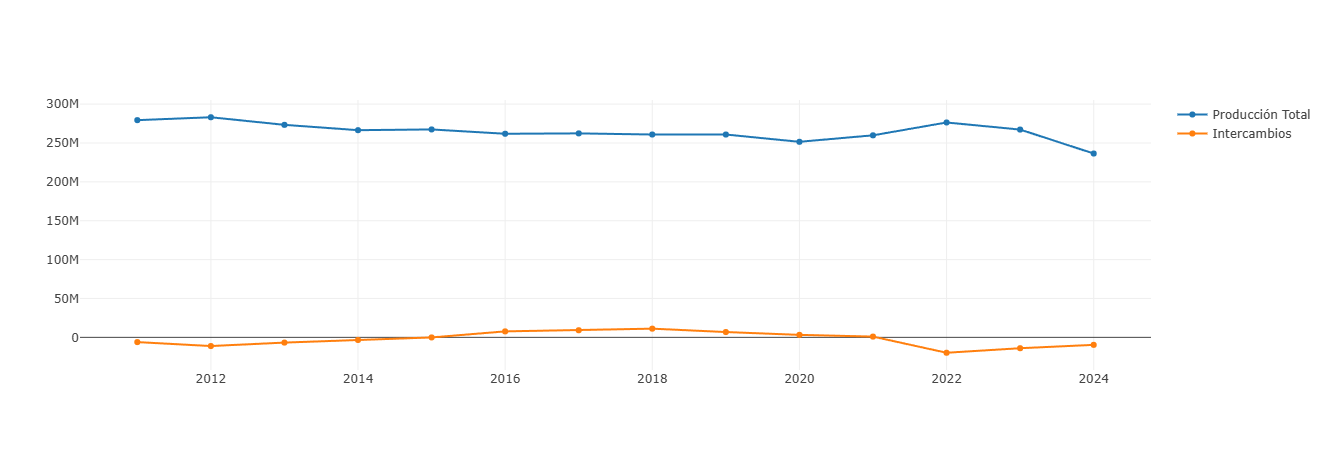

defined function AnalisisCrecimientoProduccion

In [34]:
def AnalisisCrecimientoProduccion(dataFrameBalance: DataFrame): Unit = {
    val produccionTotalAnual = dataFrameBalance
        .filter(col("Familia") !== "Demanda") // Excluir filas con "Demanda"
        .filter(col("Compuesto") === false)    // Filtrar las fuentes no compuestas
        .filter(date_format(col("FechaCompleta"), "yyyy") =!= "2010")  // Excluir el año 2010
        .groupBy(date_format(col("FechaCompleta"), "yyyy").as("Año"))  // Agrupar por año
        .agg(sum("Valor").as("ValorTotal"))     // Calcular la suma de la producción por año
        .orderBy("Año")                        // Ordenar por año

    val saldoIntercambiosAnual = dataFrameBalance // Excluir filas con "Demanda"
        .filter(col("Tipo") === "Saldo I. internacionales")    // Filtrar las fuentes no compuestas
        .filter(date_format(col("FechaCompleta"), "yyyy") =!= "2010")  // Excluir el año 2010
        .groupBy(date_format(col("FechaCompleta"), "yyyy").as("Año"))  // Agrupar por año
        .agg(sum("Valor").as("ValorTotal"))     // Calcular la suma de la producción por año
        .orderBy("Año")                        // Ordenar por año

    // Obtener las fechas y valores de la producción anual
    val fechas = produccionTotalAnual.select("Año").as[String].collect.toSeq
    val valorProduccion = produccionTotalAnual.select("ValorTotal").as[Double].collect.toSeq
    val valorIntercambios = saldoIntercambiosAnual.select("ValorTotal").as[Double].collect.toSeq
    // Crear la traza para el gráfico
    val produccion = Scatter(fechas, valorProduccion, name = "Producción Total")
    val intercambios = Scatter(fechas, valorIntercambios, name = "Intercambios")
    val data = Seq(produccion, intercambios)
    plot(data)
}



AnalisisCrecimientoProduccion(dataFrameBalance)

In [ ]:
def AnalisisSaldoIntercambios(dataFrameBalance: DataFrame): Unit = {
    val saldoAnual = dataFrameBalance // Excluir filas con "Demanda"
        .filter(col("Tipo") === "Saldo I. internacionales")    // Filtrar las fuentes no compuestas
        .filter(date_format(col("FechaCompleta"), "yyyy") =!= "2010")  // Excluir el año 2010
        .groupBy(date_format(col("FechaCompleta"), "yyyy").as("Año"))  // Agrupar por año
        .agg(sum("Valor").as("ValorTotal"))     // Calcular la suma de la producción por año
        .orderBy("Año")                        // Ordenar por año

    // Obtener las fechas y valores de la producción anual
    val fechas = saldoAnual.select("Año").as[String].collect.toSeq
    val valores = saldoAnual.select("ValorTotal").as[Double].collect.toSeq

    // Crear la traza para el gráfico
    val produccion = Scatter(fechas, valores, name = "Saldo itercambios")
    val importación = 
    val data = Seq(trace)
    plot(data)
}

Saldo I. internacional

AnalisisSaldoIntercambios(dataFrameBalance)

In [ ]:
val EnergiasParaAnalizar = Seq("Generación renovable", "Generación no renovable")
AnalisisEnergiasAnual(EnergiasParaAnalizar, dataFrameBalance)

collect at cmd11.sc:12

15 / 15

collect at cmd11.sc:12

15 / 15

collect at cmd11.sc:12

8 / 8

collect at cmd11.sc:12

8 / 8

collect at cmd11.sc:12

8 / 8

collect at cmd11.sc:12

8 / 8

collect at cmd11.sc:12

8 / 8

collect at cmd11.sc:12

8 / 8

collect at cmd11.sc:13

15 / 15

collect at cmd11.sc:13

15 / 15

collect at cmd11.sc:13

8 / 8

collect at cmd11.sc:13

8 / 8

collect at cmd11.sc:13 
 (kill)

0 + 3 / 8

collect at cmd11.sc:13 
 (kill)

0 + 3 / 8

collect at cmd12.sc:15

15 / 15

collect at cmd12.sc:15

8 / 8

collect at cmd12.sc:15

8 / 8

collect at cmd12.sc:15

8 / 8

collect at cmd12.sc:15

8 / 8

collect at cmd12.sc:15

15 / 15

collect at cmd12.sc:15

8 / 8

collect at cmd12.sc:15

8 / 8

collect at cmd12.sc:15

8 / 8

collect at cmd12.sc:15

8 / 8

collect at cmd12.sc:16

15 / 15

collect at cmd12.sc:16

8 / 8

collect at cmd12.sc:16

8 / 8

collect at cmd12.sc:16

8 / 8

collect at cmd12.sc:16

8 / 8

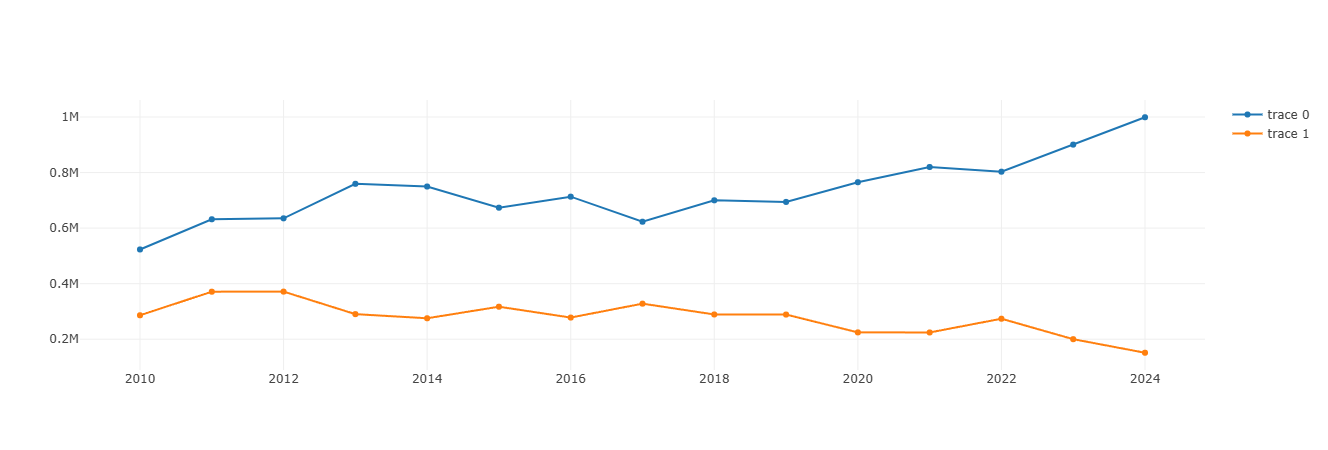

defined function AnalisisGruposEnergias
bajasEmisiones: Seq[String] = List(
  "Residuos renovables",
  "Solar fotovoltaica",
  "Solar t\u00e9rmica",
  "Otras renovables",
  "Nuclear",
  "Hidroe\u00f3lica",
  "Generaci\u00f3n renovable",
  "E\u00f3lica",
  "Hidr\u00e1ulica",
  "Turbinaci\u00f3n bombeo"
)
altasEmisiones: Seq[String] = List(
  "Turbina de gas",
  "Residuos no renovables",
  "Cogeneraci\u00f3n",
  "Motores di\u00e9sel",
  "Carb\u00f3n",
  "Ciclo combinado",
  "Turbina de vapor",
  "Fuel + Gas"
)

In [13]:
def AnalisisGruposEnergias(listaGrupos: Seq[Seq[String]], dataFrameBalance: DataFrame): Unit = {
    
    def valorAnual(df: DataFrame): DataFrame = {
        df.groupBy(col("FechaCompleta"))
          .agg(sum("Valor").as("ValorTotalPorDia"))
          .groupBy(date_format(col("FechaCompleta"), "yyyy").as("Año"))
          .agg(avg("ValorTotalPorDia").as("ValorPromedio"))
          .orderBy("Año")
    }
    
    val listaDf = listaGrupos.map{
        grupo => dataFrameBalance.filter(col("Tipo").isin(grupo:_*))
    }
    val valores = listaDf.map(valorAnual(_))
    val seqValores = valores.map(valor => valor.select("ValorPromedio").as[Double].collect.toSeq)
    val fechas = valores.head.select("Año").as[String].collect.toSeq

    val traces = listaGrupos.zip(seqValores).map { case (nombre, seqValor) =>
        Scatter(fechas, seqValor)
    }

  val data = traces
  plot(data)
}

val bajasEmisiones = Seq(
  "Residuos renovables",
  "Solar fotovoltaica",
  "Solar térmica",
  "Otras renovables",
  "Nuclear",
  "Hidroeólica",
  "Generación renovable",
  "Eólica",
  "Hidráulica",
  "Turbinación bombeo"
)
val altasEmisiones = Seq(
  "Turbina de gas",
  "Residuos no renovables",
  "Cogeneración",
  "Motores diésel",
  "Carbón",
  "Ciclo combinado",
  "Turbina de vapor",
  "Fuel + Gas"
)


AnalisisGruposEnergias(Seq(bajasEmisiones, altasEmisiones), dataFrameBalance)

### Analisis mensual de un año de distintos tipos de energias

In [6]:
def AnalisisEnergiasMensual(listaEnergias: Seq[String], df: DataFrame): Unit = {
  // Agrupar y calcular la media para datos renovables
  def calcularMediaMensual(df1: DataFrame, tipo: String): DataFrame = {
    df1.filter(col("Tipo") === tipo)
      .groupBy(date_format(col("Fecha"), "yyyy-MM").as("Mes"))
      .agg(avg("Valor").as("ValorPromedio"))
      .orderBy("Mes")
  }

  val valores = listaEnergias.map(tipoEnergia => calcularMediaMensual(df, tipoEnergia))
  val seqFechas = valores.head.select("Mes").as[String].collect.toSeq
  val seqValores = valores.map(valor => valor.select("ValorPromedio").as[Double].collect.toSeq)

  val traces = listaEnergias.zip(seqValores).map { case (nombre, seqValor) =>
    Scatter(seqFechas, seqValor, name = nombre)
  }

  val data = traces
  plot(data)
}

val dataFrameBalance2024 = dataFrameBalance.filter(date_format(col("FechaCompleta"),"yyyy") === "2014") //Elegimos año
val EnergiasParaAnalizar = Seq("Hidráulica", "Solar fotovoltaica", "Nuclear", "Ciclo combinado", "Eólica","Carbón")

AnalisisEnergiasMensual(EnergiasParaAnalizar, dataFrameBalance2024)

: 

#### Top 5 tipos de energías por su generación anual

In [ ]:
def top5anual (Año: Int) = {
val energiasOrdenadas= dataFrameBalance
    //.filter(date_format(col("Fecha"),"yyyy") === Año) //Año
    .filter(col("Familia") =!= "Demanda")
    .filter(!col("Tipo").isin("Generación renovable", "Generación no renovable"))
    .groupBy($"Tipo")
    //.groupBy(date_format(col("FechaCompleta"), "yyyy-MM").as("Mes"))
    .agg(sum("Valor").as[Double].as("ValorTotal"))
    .orderBy($"ValorTotal".desc)

val seqValores = energiasOrdenadas.select($"ValorTotal").as[Double].head(5).toSeq
val seqTipo = energiasOrdenadas.select($"Tipo").as[String].head(5).toSeq
val layout = Layout("Top 5 fuentes de producción en 2011")
val data = Seq(Bar(
    seqTipo,
    seqValores,
))

plot(data, layout)
}
top5anual(2011)

head at cmd10.sc:11

15 / 15

head at cmd10.sc:11 
 (kill)

120 + 19 / 200

## Crecimiento de las energias

first at cmd72.sc:26

3 / 3

first at cmd72.sc:26

8 / 8

first at cmd72.sc:26

8 / 8

first at cmd72.sc:26

8 / 8

first at cmd72.sc:26

8 / 8

first at cmd72.sc:26

1 / 1

collect at cmd72.sc:31

3 / 3

collect at cmd72.sc:31

8 / 8

collect at cmd72.sc:31

8 / 8

collect at cmd72.sc:31

8 / 8

collect at cmd72.sc:31

8 / 8

collect at cmd72.sc:32

3 / 3

collect at cmd72.sc:32

8 / 8

collect at cmd72.sc:32

8 / 8

collect at cmd72.sc:32

8 / 8

collect at cmd72.sc:32

8 / 8

Media de Crecimiento Anual: -5.31%


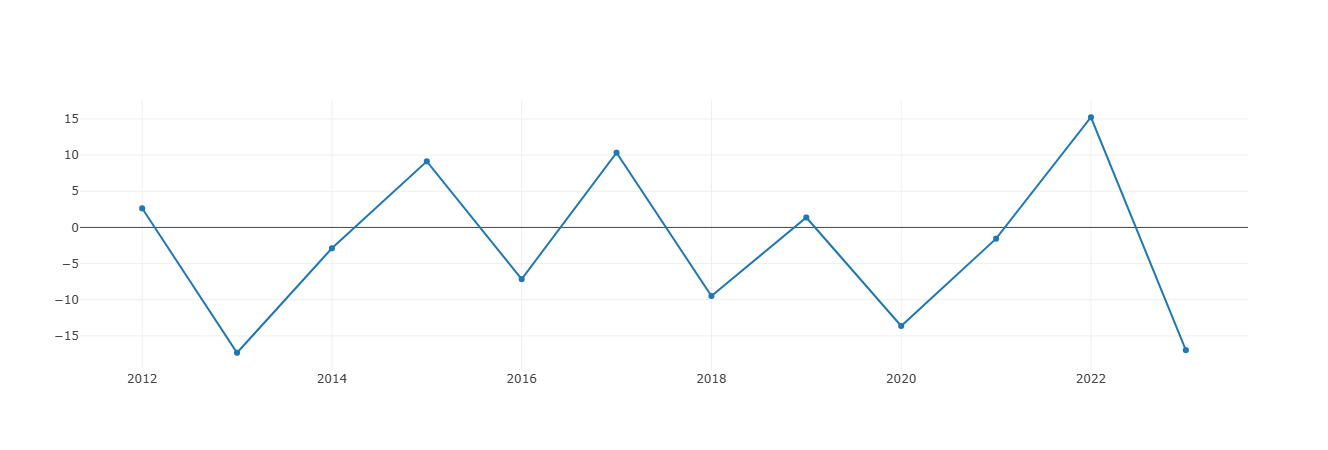

import org.apache.spark.sql.expressions.Window

import org.apache.spark.sql.functions._

defined function crecimientoPorcentualEnergia
res72_3: String = "plot-d6f9b17f-80a9-499a-aa6f-09dd387d218c"

In [73]:
import org.apache.spark.sql.expressions.Window
import org.apache.spark.sql.functions._
def crecimientoPorcentualEnergia(df: DataFrame, energia: String) = {
val df = dataFrameBalance.groupBy($"Tipo", date_format(col("FechaCompleta"), "yyyy").as("Año"))
  .agg(sum("Valor").as("ValorAnual")) // Renombrar la suma para mayor claridad
  .filter($"Tipo" === energia)
  .filter($"Año" =!= 2010)
  .orderBy("Año")

// Definir la ventana para calcular el valor del año anterior
val windowSpec = Window.partitionBy("Tipo").orderBy("Año")

// Calcular el valor del año anterior
val dfWithPreviousYear = df.withColumn("ValorAnterior", lag("ValorAnual", 1).over(windowSpec))

// Calcular el crecimiento porcentual
val dfWithGrowth = dfWithPreviousYear.withColumn(
  "CrecimientoAnualPorcentaje",
  when(col("ValorAnterior").isNotNull, (col("ValorAnual") - col("ValorAnterior")) / col("ValorAnterior") * 100)
    .otherwise(lit(null)) // Si no hay valor anterior, dejar nulo
).filter($"CrecimientoAnualPorcentaje".isNotNull)

val mediaCrecimientoAnual = dfWithGrowth
    .agg(avg("CrecimientoAnualPorcentaje").as("MediaCrecimientoAnual")) //Calcular media
    .select("MediaCrecimientoAnual")
    .as[Double]
    .first()



val seqAños = dfWithGrowth.filter($"Año" =!= 2024).select("Año").as[String].collect.toSeq
val seqPorcentajes = dfWithGrowth.filter($"Año" =!= 2024).select("CrecimientoAnualPorcentaje").as[Double].collect.toSeq
val trace = Scatter(seqAños, seqPorcentajes, name = "Crecimiento")
val data = Seq(trace)
    
printf("Media de Crecimiento Anual: %.2f%%\n", mediaCrecimientoAnual )
plot(data)
}
crecimientoPorcentualEnergia(dataFrameBalance, "Generación no renovable")

In [72]:
import org.apache.spark.sql.functions._
import org.apache.spark.sql.expressions.Window

def añosParaSustituir(
  dataFrame: DataFrame,
  energia1: String,
  energia2: String,
  añosParaCalculo: Int = 5 // Número de años históricos a considerar para el cálculo del crecimiento anual
): Int = {
  
  // Definir una ventana por Tipo y ordenando por Año
  val windowSpec = Window.partitionBy("Tipo").orderBy("Año")

  // Calcular la producción anual por tipo de energía
  val df = dataFrame.groupBy($"Tipo", date_format(col("FechaCompleta"), "yyyy").as("Año"))
    .agg(sum("Valor").as("ValorAnual"))
    .filter($"Tipo".isin(energia1, energia2)) // Filtrar solo las energías que nos interesan

  // Calcular el crecimiento anual de cada energía
  val dfWithGrowth = df.withColumn("ValorAnterior", lag("ValorAnual", 1).over(windowSpec))
    .withColumn("CrecimientoAnual", 
      when(col("ValorAnterior").isNotNull, (col("ValorAnual") - col("ValorAnterior")) / col("ValorAnterior"))
      .otherwise(lit(null)))

  // Calcular el crecimiento anual promedio de los últimos años para ambas energías
  val crecimientoPromedioPorEnergia = dfWithGrowth
    .filter(col("CrecimientoAnual").isNotNull)
    .groupBy("Tipo")
    .agg(avg("CrecimientoAnual").as("CrecimientoPromedio"))
    .filter(col("Tipo").isin(energia1, energia2))
    .collect()
    .map(row => (row.getString(0), row.getDouble(1)))
    .toMap

  // Obtener los valores iniciales y los crecimientos anuales promedio
  val valorInicialEnergia1 = df.filter(col("Tipo") === energia1).orderBy(desc("Año")).select("ValorAnual").as[Double].head
  val valorInicialEnergia2 = df.filter(col("Tipo") === energia2).orderBy(desc("Año")).select("ValorAnual").as[Double].head

  val crecimientoAnualEnergia1 = crecimientoPromedioPorEnergia.getOrElse(energia1, 0.0)
  val crecimientoAnualEnergia2 = crecimientoPromedioPorEnergia.getOrElse(energia2, 0.0)

  // Variables para simulación
  var valorProyectadoEnergia1 = valorInicialEnergia1
  var valorProyectadoEnergia2 = valorInicialEnergia2
  var añosNecesarios = 0

  // Simular el crecimiento año a año hasta que la energía 1 supere a la energía 2
  while (valorProyectadoEnergia1 < valorProyectadoEnergia2) {
    valorProyectadoEnergia1 *= (1 + crecimientoAnualEnergia1)
    valorProyectadoEnergia2 *= (1 + crecimientoAnualEnergia2)
    añosNecesarios += 1

    // Por si el crecimiento es negativo o muy bajo, evitar un bucle infinito
    if (añosNecesarios > 100) {
      println("El crecimiento no es suficiente para que la energía 1 sustituya a la energía 2 en un tiempo razonable.")
      return -1 // Indicar que no es posible en un tiempo razonable
    }
  }

  añosNecesarios
}

// Ejemplo de uso
val años = añosParaSustituir(dataFrameBalance, "Generación renovable", "Generación no renovable")
println(s"Se necesitarían $años años para que 'Renovable' sustituya a 'No renovable'.")


collect at cmd71.sc:30

3 / 3

collect at cmd71.sc:30

8 / 8

collect at cmd71.sc:30

8 / 8

head at cmd71.sc:36

3 / 3

head at cmd71.sc:36

8 / 8

head at cmd71.sc:37

3 / 3

head at cmd71.sc:37

8 / 8

Se necesitarían 0 años para que 'Renovable' sustituya a 'No renovable'.


import org.apache.spark.sql.functions._

import org.apache.spark.sql.expressions.Window


defined function añosParaSustituir
años: Int = 0

In [3]:
dataFrameBalance.show()

show at cmd2.sc:1

1 / 1

+---------+----------+---------+-------------------+-------------------+----------+--------------+
|  Familia|      Tipo|Compuesto|      FechaCompleta|         Porcentaje|     Valor|BajasEmisiones|
+---------+----------+---------+-------------------+-------------------+----------+--------------+
|Renovable|Hidráulica|    false|2013-12-31 23:00:00| 0.2070493282098544| 73065.052|          true|
|Renovable|Hidráulica|    false|2014-01-01 23:00:00|0.23631205453294465| 89171.545|          true|
|Renovable|Hidráulica|    false|2014-01-02 23:00:00| 0.2735980903206654|102502.527|          true|
|Renovable|Hidráulica|    false|2014-01-03 23:00:00|0.24018151631870316|106840.706|          true|
|Renovable|Hidráulica|    false|2014-01-04 23:00:00|0.28984651129433686|117217.635|          true|
|Renovable|Hidráulica|    false|2014-01-05 23:00:00| 0.3229806730258387|110841.694|          true|
|Renovable|Hidráulica|    false|2014-01-06 23:00:00|0.40968176867979184| 137057.77|          true|
|Renovable

In [10]:
dataFrameBalance
    .filter($"FechaCompleta" === "2021-01-08 23:00:00")
    .orderBy(desc("Valor"))
    .show()

show at cmd9.sc:3

15 / 15

+------------+--------------------+---------+-------------------+--------------------+------------------+--------------+
|     Familia|                Tipo|Compuesto|      FechaCompleta|          Porcentaje|             Valor|BajasEmisiones|
+------------+--------------------+---------+-------------------+--------------------+------------------+--------------+
|     Demanda|     Demanda en b.c.|     true|2021-01-08 23:00:00|                 1.0|        773296.979|         false|
|   Renovable|Generación renovable|     true|2021-01-08 23:00:00|                 1.0|393069.52949999995|          true|
|No-Renovable|Generación no ren...|     true|2021-01-08 23:00:00|                 1.0|366762.75350000005|         false|
|   Renovable|              Eólica|    false|2021-01-08 23:00:00|  0.6249911849247018|        245664.991|          true|
|No-Renovable|             Nuclear|    false|2021-01-08 23:00:00| 0.43910936828540303|        161048.961|          true|
|   Renovable|          Hidráuli